In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from hmmlearn import hmm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import functions_data_processing as fsd
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from itertools import combinations

In [2]:
# This cell changes the values of the df.csv file in order for the absent state to have a value of 0 instead of 0.1 and the present state to have a value of 1 instead of 0.9
# Furthermore it adds a new column in which we have both values of Microwave and Default combined

df_imported = pd.read_csv('df.csv', index_col=0)
df_imported = df_imported
df_imported.index = pd.to_datetime(df_imported.index)
df = pd.DataFrame()
df['Microwave'] = df_imported['Microwave-Default']
df['Default'] = df_imported['Default']
df['Ground Truth'] = df_imported['Ground Truth']
df['Microwave - Default (combined)'] = 'temporary'

df =df.mask(df==0.9, 1)
df =df.mask(df==0.1, 0)

mask1 = (df['Microwave']==1.0) & (df['Default']==1.0)
mask2 = (df['Microwave']==0.0) & (df['Default']==1.0)
mask3 = (df['Microwave']==0.0) & (df['Default']==0.0)
mask4 = (df['Microwave']==1.0) & (df['Default']==0.0)

df['Microwave - Default (combined)'] = ''
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask1, '11')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask2, '01')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask3, '00')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask4, '10')
df.iloc[115:130]



,Microwave,Default,Ground Truth,Microwave - Default (combined)
2016-01-01 06:55:00,1.0,1.0,1.0,11
2016-01-01 06:56:00,1.0,1.0,1.0,11
2016-01-01 06:57:00,1.0,1.0,1.0,11
2016-01-01 06:58:00,1.0,1.0,1.0,11
2016-01-01 06:59:00,1.0,1.0,1.0,11
2016-01-01 07:00:00,0.0,0.0,0.0,00
2016-01-01 07:01:00,0.0,0.0,0.0,00
2016-01-01 07:02:00,0.0,0.0,0.0,00
2016-01-01 07:03:00,0.0,0.0,0.0,00
2016-01-01 07:04:00,0.0,0.0,0.0,00


In [3]:
df['Microwave - Default (combined)'].loc['2016-01-01 05:00:00' : '2016-01-01 05:08:00	']

2016-01-01 05:00:00    11
2016-01-01 05:01:00    11
2016-01-01 05:02:00    11
2016-01-01 05:03:00    11
2016-01-01 05:04:00    11
2016-01-01 05:05:00    11
2016-01-01 05:06:00    11
2016-01-01 05:07:00    11
2016-01-01 05:08:00    11
Name: Microwave - Default (combined), dtype: object

In [4]:
# A function that selects a section of the data frame based on a starting date and interval

def interval_model(data_frame, starting_date, interval):
    
    s_date = pd.to_datetime(starting_date, format='%Y-%m-%d %H:%M:%S.%f')
    data_frame = data_frame.loc[s_date : s_date + interval]
    return data_frame
   


In [5]:
# An example of using the function interval_model defined above
df_model = df['Microwave - Default (combined)']

df_model = interval_model(data_frame= df_model, starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))

df_model.iloc[100:125]



2016-01-01 06:40:00    11
2016-01-01 06:41:00    11
2016-01-01 06:42:00    11
2016-01-01 06:43:00    11
2016-01-01 06:44:00    11
2016-01-01 06:45:00    11
2016-01-01 06:46:00    11
2016-01-01 06:47:00    11
2016-01-01 06:48:00    11
2016-01-01 06:49:00    11
2016-01-01 06:50:00    11
2016-01-01 06:51:00    11
2016-01-01 06:52:00    11
2016-01-01 06:53:00    11
2016-01-01 06:54:00    11
2016-01-01 06:55:00    11
2016-01-01 06:56:00    11
2016-01-01 06:57:00    11
2016-01-01 06:58:00    11
2016-01-01 06:59:00    11
2016-01-01 07:00:00    00
2016-01-01 07:01:00    00
2016-01-01 07:02:00    00
2016-01-01 07:03:00    00
2016-01-01 07:04:00    00
Name: Microwave - Default (combined), dtype: object

In [6]:
# The following cells are used just for testing and getting a feel for how the HMM model is deployed and can be ignored 



''' A function that returns a list of lists where each list has 4 values based on the counted values of the ostates in the status input variable'''
def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.9, 0.1])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.1, 0.4, 0.25],
                           [0.2, 0.5, 0.1, 0.2]])

# Transition matrix of hidden states
trans_mat = np.array([[0.95, 0.05], [0.05, 0.95]])





In [7]:

lst = [0] *7*24
for i in range(1,7*24,1):
    lst[i-1] = df_model.tolist()[((i-1)*60):(i*60)]
   
    
lst[167] = df_model.tolist()[(167*60):(168*60)]

print(len(lst[167]))




60


In [8]:


observations = lst


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])


# Build the model
# Set up model:
model = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials,
        n_iter=50,
        init_params='')

model.n_features = len(o_states)
model.startprob_ = start_probs
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs
model.fit(data)

# Estimate state
logprob, state_ests = model.decode(data)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


In [9]:


def plot_dfs(data_frame, attributes, graphing_interval):
    start_date = pd.to_datetime(graphing_interval[0])
    end_date = pd.to_datetime(graphing_interval[1])

    sliced_df = data_frame.loc[start_date:end_date, attributes]

    sns.lineplot(data=sliced_df)
    plt.xlabel('Time')
    plt.ylabel('Attribute')
    plt.title('Plot of Attributes')
    plt.show()

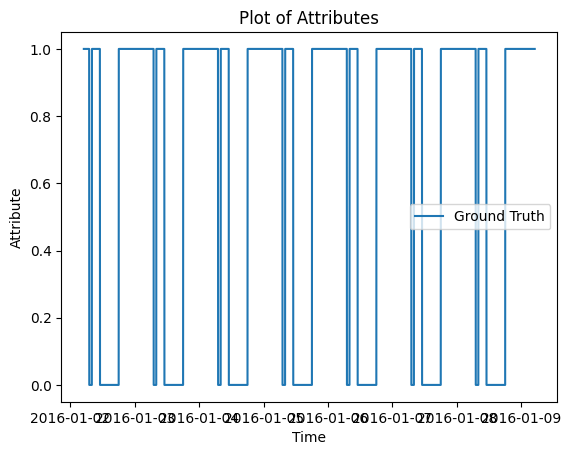

In [10]:
#time = range(len(state_ests))
#ests_df = pd.DataFrame(data=state_ests[:500], index=df.index[:500], columns=['Presence'])
#g = sns.lineplot(data=ests_df).set(title='Estimated presence')
plot_dfs(df, ['Ground Truth'], ['2016-01-02 05:00:00', '2016-01-09 05:00:00'])


In [11]:
# Print states
print("Estimated states")
print([id2hstates[x] for x in state_ests])
print('------------------------------------')
print("Learned emission probs:")
print(model.emissionprob_)
print('------------------------------------')
print("Learned transition matrix:")
print(model.transmat_)

Estimated states
['present', 'present', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'absent', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'present', 'pr

In [12]:

# This cell does the "aggregation" in the sense that 60 minute intervals of 60 values are transformed into one value of 0 or 1 based on which value is more present
# in that 60 minute intreval

y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))

y_true = y_true_original
ss = ShuffleSplit(n_splits=5, test_size=0.3)


list_true = [0] *7*24
for i in range(1,7*24,1):
    list_true[i-1] = y_true.tolist()[((i-1)*60):(i*60)]
   
    
list_true[167] = y_true.tolist()[(167*60):(168*60)]

l = []
for status in list_true:
    row = sequence2counts(status, dict(zip(range(len([0,1])), [0,1])))
    l.append(row)
y_true = np.array(l, dtype=int)



for i in range(y_true.shape[0]):
    if y_true[i,0]>=y_true[i,1]:
        y_true[i]=0
    else:
        y_true[i]=1



y_true = y_true[:,0]

y_pred_proba_all = np.zeros(len(y_true))





Split: 0
[[ 0 14]
 [ 1 36]]
Split: 1
[[ 0 21]
 [ 1 29]]
Split: 2
[[ 0 21]
 [26  4]]
Split: 3
[[ 0 16]
 [32  3]]
Split: 4
[[ 0 16]
 [ 1 34]]


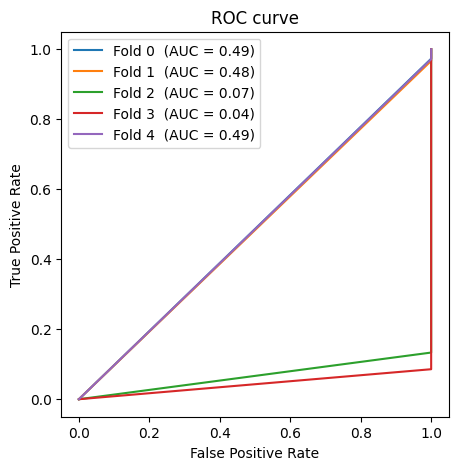

In [13]:

#Markov Chain - 1 (with aggregation)


y_pred_proba_all = []
y_true_all = []

model.n_features = len(o_states)
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs


fig, ax = plt.subplots(figsize=(5, 5))

for split_number, (train_index, test_index) in enumerate(ss.split(data, y_true)):
    model.startprob_ = start_probs
    print("Split:", split_number)
    
    
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]

    # Fit the model and predict probabilities for the test set
    model.fit(X_train)
    logprob, state_ests = model.decode(X_test)

    y_pred_proba = state_ests
    y_pred_proba_all.extend(y_pred_proba)
    y_true_all.extend(y_true[test_index])


    print(confusion_matrix(y_true[test_index], y_pred_proba))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))



# Plot the ROC curve
#plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()




MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Split: 0
[[ 971    0]
 [2054    0]]
Split: 1
[[ 964    0]
 [2061    0]]
Split: 2
[[ 997    0]
 [2028    0]]
Split: 3
[[1011    0]
 [2014    0]]
Split: 4
[[1057    0]
 [1968    0]]


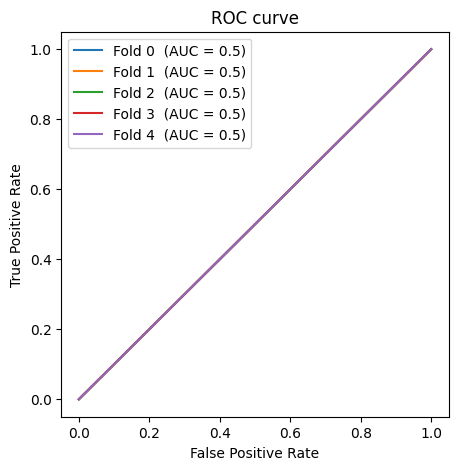

In [14]:
#Markov Chain - 2 (without aggregation)

y_true_all_2 = []

y_pred_proba_all_2 = []
y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.9, 0.1])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.1, 0.4, 0.25],
                           [0.2, 0.5, 0.1, 0.2]])

# Transition matrix of hidden states
trans_mat = np.array([[0.95, 0.05], [0.05, 0.95]])

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])





# Build the model
# Set up model:
model = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1,
        n_iter=50,
        init_params='')

model.n_features = len(o_states)
model.startprob_ = start_probs
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs



x= data
y = y_true_original

fig, ax = plt.subplots(figsize=(5, 5))

for split_number, (train_index, test_index) in enumerate(ss.split(x, y)):
    model.startprob_ = start_probs
    print("Split:", split_number)
    
    
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model.fit(X_train)
    logprob, state_ests = model.decode(X_test)

    y_pred_proba = state_ests
    y_pred_proba_all_2.extend(y_pred_proba)
    y_true_all_2.extend(y_true_original[test_index])


    #print(confusion_matrix(y_true_original[test_index], y_pred_proba))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(confusion_matrix(y[test_index], y_pred_proba))

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))




# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()



3360 6721


Text(0.5, 1.0, 'Linear kernel for SVM')

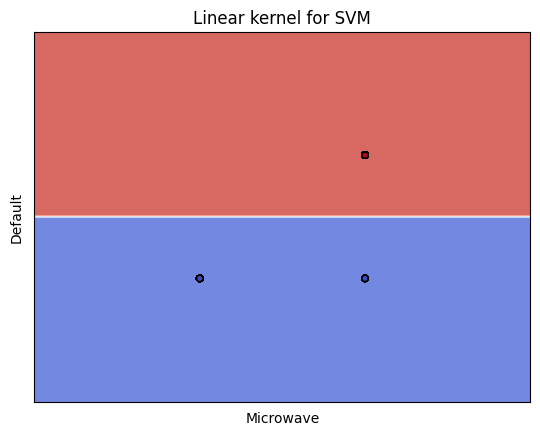

In [15]:
# SVM

df = interval_model(data_frame= df, starting_date='2016-01-21 05:00:00', interval=datetime.timedelta(days=7))

ss = ShuffleSplit(n_splits=5, test_size=0.3)

classifier = svm.SVC(kernel="linear", C=1)
# Predicts whether someone is present or absent 
# Inputs: Micorwave, Default

x = np.zeros([10081, 2])
x[:,0] = df['Microwave']
x[:,1] = df['Default']

y = np.zeros([10081,1])
y = df['Ground Truth']

absent =0
present =0

absent = np.count_nonzero(y == 0)
present = np.count_nonzero(y == 1)

print(absent, present)

data = classifier.fit(x,y)

fig, sub = plt.subplots()
ax = sub
title = "Linear kernel for SVM"

disp = DecisionBoundaryDisplay.from_estimator(
        data,
        x,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel="Microwave",
        ylabel="Default",
    )
ax.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)







Fold: 0 
 [[1003    0]
 [ 378 1644]]
Fold: 1 
 [[ 998    0]
 [ 371 1656]]
Fold: 2 
 [[1020    0]
 [ 383 1622]]
Fold: 3 
 [[1011    0]
 [ 372 1642]]
Fold: 4 
 [[1021    0]
 [ 389 1615]]


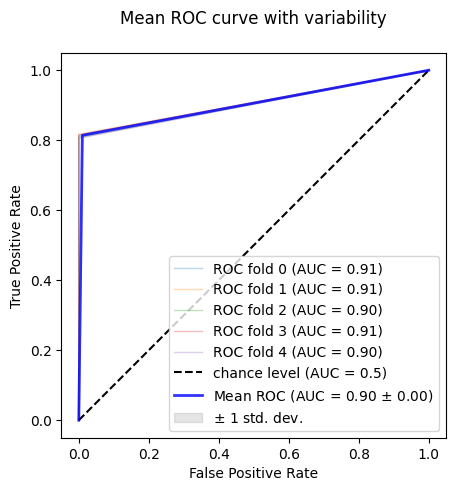

In [16]:
ss = ShuffleSplit(n_splits=5, test_size=0.3)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(5, 5))

for fold, (train, test) in enumerate(ss.split(x,y)):
    classifier.fit(x[train],y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        x[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    print("Fold:", fold, "\n", confusion_matrix(y[test], classifier.predict(x[test])))


ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.show()
    